In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [122]:
import pandas as pd 
data_30 = pd.read_csv('/content/drive/My Drive/data/dataset/diseases/di_30.txt', header = None)
data_40 = pd.read_csv('/content/drive/My Drive/data/dataset/diseases/di_40.txt', header = None)
data_price = pd.read_csv('/content/drive/My Drive/data/dataset/diseases/di_code.csv')

In [123]:
def FG391_filter(data_frame):
  data_list = []
  for i in data_frame.index:
    if data_frame.loc[i][0][3:8] == 'FG391':
      data_list.append(data_frame.loc[i][0][3:-2])

  import numpy as np
  data_list = np.array(data_list)
  #입력 데이터 중 'FG391' 로시작하는 리스트 저장 

  sep_data = []
  for i in range(len(data_list)):
    sep_data.append(data_list[i].split(' '))
  #입력데이터 질병별로 ' '로 분류 

  tot_price_list = []
  for n in sep_data:
    tot_price = 0
    for code in data_price['d_code']:
      if code in n:
        tot_price += int(data_price[data_price['d_code'] == code]['price'])
    tot_price_list.append(tot_price)
    # 분류된 데이터와 질병에 대한 진료비(price) 비교하여, 각 컬럼당 총 비용 저장
    
  return data_list, sep_data, tot_price_list

In [124]:
data_30_list, sep_data_30, price_30_list = FG391_filter(data_30)
data_40_list, sep_data_40, price_40_list = FG391_filter(data_40)

In [125]:
import numpy as np
X = np.concatenate((data_30_list, data_40_list), axis=None)
y = price_30_list + price_40_list
y = np.array(y)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(y.reshape(-1, 1))
y_scaled=  scaler.transform(y.reshape(-1, 1))
print(len(X), len(y))

200 200


In [126]:
from tensorflow.keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(X)
x = token.texts_to_sequences(X)

In [127]:
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_padded = pad_sequences(x, maxlen = 35)#단어수를 100개로 맞춰준다. 100개째를 넘는 단어는 버리고, 모자란 부분은 0으로 채워준다. 

In [128]:
x_padded

array([[ 0,  0,  0, ..., 41, 51, 22],
       [ 0,  0,  0, ..., 91,  5, 60],
       [ 0,  0,  0, ..., 52, 37, 23],
       ...,
       [ 0,  0,  0, ..., 43, 35, 49],
       [ 0,  0,  0, ..., 68, 20,  7],
       [ 0,  0,  0, ..., 40,  5, 15]], dtype=int32)

In [129]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_padded, y_scaled,  train_size=0.9)

In [130]:
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM
from tensorflow.keras.models import Sequential

from numpy import array
import tensorflow as tf

word_size = len(token.word_index) +1
model = Sequential()
model.add(Embedding(word_size, 50, input_length = 35)) #입력 될 단어수는 우리는 padding과정을 거쳐 각 문장당 4개의 입력으로 분할
model.add(LSTM(35, activation = 'tanh'))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer= 'adam')
model.fit(X_train, y_train, epochs= 200, batch_size = 10)

Epoch 1/200
18/18 [==============================] - 0s 8ms/step - loss: 0.9912
Epoch 2/200
18/18 [==============================] - 0s 9ms/step - loss: 0.6816
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 0.2854
Epoch 4/200
18/18 [==============================] - 0s 8ms/step - loss: 0.1771
Epoch 5/200
18/18 [==============================] - 0s 9ms/step - loss: 0.1244
Epoch 6/200
18/18 [==============================] - 0s 8ms/step - loss: 0.0950
Epoch 7/200
18/18 [==============================] - 0s 8ms/step - loss: 0.0610
Epoch 8/200
18/18 [==============================] - 0s 8ms/step - loss: 0.0452
Epoch 9/200
18/18 [==============================] - 0s 8ms/step - loss: 0.0378
Epoch 10/200
18/18 [==============================] - 0s 8ms/step - loss: 0.0342
Epoch 11/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0469
Epoch 12/200
18/18 [==============================] - 0s 8ms/step - loss: 0.0306
Epoch 13/200
18/18 [=================

In [131]:
 predict = model.predict(X_test)
print('test set 예측하기')
 for i in range(len(predict)):
   print('실제값 : %.2f  예측값 : %.2f'%(scaler.inverse_transform(y_test[i]),  scaler.inverse_transform(predict[i])))

test set 예측하기
실제값 : 648400.00  예측값 : 570711.81
실제값 : 548200.00  예측값 : 471366.09
실제값 : 829200.00  예측값 : 855608.50
실제값 : 863000.00  예측값 : 771648.06
실제값 : 389300.00  예측값 : 355017.94
실제값 : 645400.00  예측값 : 679842.12
실제값 : 447600.00  예측값 : 478530.78
실제값 : 560400.00  예측값 : 447060.75
실제값 : 674900.00  예측값 : 553656.56
실제값 : 361200.00  예측값 : 453153.72
실제값 : 759000.00  예측값 : 701743.62
실제값 : 578300.00  예측값 : 544106.88
실제값 : 973200.00  예측값 : 794550.62
실제값 : 782200.00  예측값 : 877615.62
실제값 : 429500.00  예측값 : 483020.12
실제값 : 797800.00  예측값 : 857233.56
실제값 : 544400.00  예측값 : 426916.72
실제값 : 221800.00  예측값 : 311826.72
실제값 : 309200.00  예측값 : 341233.69
실제값 : 254100.00  예측값 : 178524.59


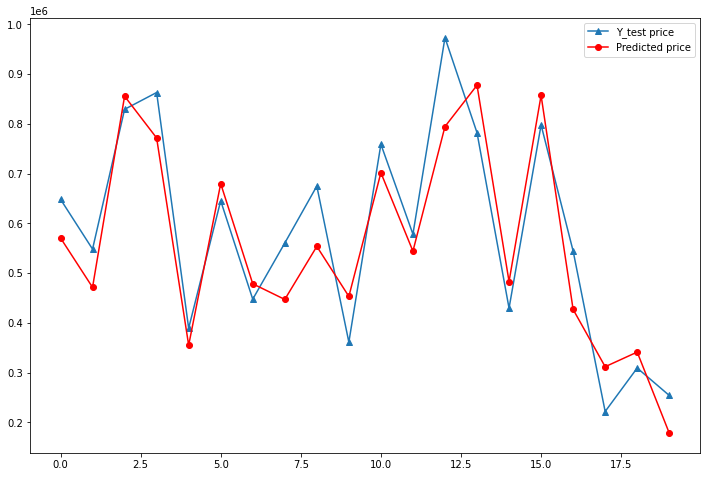

In [135]:
import matplotlib.pyplot as plt
x_len = len(X_test)
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(y_test).reshape(len(y_test)), marker = '^', label = 'Y_test price')
plt.plot(scaler.inverse_transform(predict).reshape(len(predict)), marker = 'o', color ='red', label = 'Predicted price')
plt.legend(loc ='best')

In [134]:
len(predict)

20